In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time

repo_name = {}

def read_data(filepath):
    d = pd.read_csv(filepath)
    return d

def clean_data():
    curr_millis = int(round(time.time()))

    d = read_data("../data/MLR/watcher.csv")
    repo = d["repo_name"]
    watch_count = d["watch_count"]
    for i in range(len(repo)):
            repo_name[repo[i]] = [watch_count[i], np.nan, np.nan, np.nan, np.nan, np.nan]

    d = read_data("../data/MLR/lang_count.csv")
    repo = d["L_repo_name"]
    lang_count = d["L_lang_count"]
    lan_sum = 0
    count = 0
    for i in range(len(repo)):
            if repo[i] in repo_name:
                    repo_name[repo[i]][1] = lang_count[i]
            if not pd.isnull(lang_count[i]):
                lan_sum += lang_count[i]
                count += 1
    
    mean_lang_count = lan_sum/count
    print(mean_lang_count)
    
    file_sum = 0
    count = 0
    d = read_data("../data/MLR/files_count.csv")
    repo = d["S_repo_name"]
    file_count = d["C_files"]
    for i in range(len(repo)):
            if not pd.isnull(file_count[i]):
                    repo_name[repo[i]][2] = file_count[i]
            if not pd.isnull(file_count[i]):
                file_sum += file_count[i]
                count += 1
    
    mean_file_count = file_sum/count
    print(mean_file_count)

    commiter_sum = 0
    count = 0
    d = read_data("../data/MLR/committer_count.csv")
    repo = d["S_repo_name"]
    committer_count = d["C_committer_count"]
    for i in range(len(repo)):
            if not pd.isnull(committer_count[i]):
                    repo_name[repo[i]][3] = committer_count[i]
            if not pd.isnull(committer_count[i]):
                commiter_sum += committer_count[i]
                count += 1
    
    mean_committer_count = commiter_sum/count
    print(mean_committer_count)

    commit_sum = 0
    count = 0
    d = read_data("../data/MLR/commit_count.csv")
    repo = d["S_repo_name"]
    commit_count = d["C_comm_count"]
    for i in range(len(repo)):
            if not pd.isnull(commit_count[i]):
                    repo_name[repo[i]][4] = commit_count[i]
            if not pd.isnull(commit_count[i]):
                commit_sum += commit_count[i]
                count += 1
    
    mean_commit_count = commit_sum/count
    print(mean_commit_count)

    d = read_data("../data/MLR/committer_date.csv")
    repo = d["S_repo_name"]
    commit_date = d["C_commit_date"]
    for i in range(len(repo)):
            if not pd.isnull(commit_date[i]):
                    dt_obj = datetime.strptime(commit_date[i][:-4],'%Y-%m-%d %H:%M:%S')
                    millisec = dt_obj.timestamp()
                    repo_name[repo[i]][5] = curr_millis - millisec
                    
    repo_name1 = repo_name.copy()
    print(len(repo_name1))
    for i in repo_name.keys():
            if pd.isnull(repo_name[i][5]):
                    del repo_name1[i]

    print(len(repo_name1))
    return (repo_name1, mean_lang_count, mean_file_count, mean_committer_count, mean_commit_count)

In [7]:
(repo_name1, mean_lang_count, mean_file_count, mean_committer_count, mean_commit_count) = clean_data()

2.5628183462
325.597920902
11.4284996691
849.54371336
400000
169216


In [8]:
df = pd.DataFrame.from_dict(repo_name1, orient='index')
df.columns = ["watch_count", "lang_count", "files_count", "committer_count", "commit_count", "commit_date"]

In [9]:
df.to_csv("../data/MLR/Final.csv")

In [10]:
data = pd.read_csv("../data/MLR/Final.csv")

In [11]:
LC = data['lang_count']
FC = data['files_count']
CC = data['committer_count']
COC = data['commit_count']
CD = data['commit_date']
WC = data['watch_count']
O = np.ones((len(FC),1))

#creating the x matix with the two features and excluding beta_0
X = np.zeros((len(FC),6))
X[:,0] = list(O)[:]
X[:,1] = LC[:]
X[:,2] = FC[:]
X[:,3] = CC[:]
X[:,4] = COC[:]
X[:,5] = CD[:]

null_val_index = np.argwhere(np.isnan(X))
for i in range(0,len(null_val_index)):
    if null_val_index[i][1] == 1:
        X[null_val_index[i][0]] = mean_lang_count
    elif null_val_index[i][1] == 2:
        X[null_val_index[i][0]] = mean_file_count
    elif null_val_index[i][1] == 3:  
        X[null_val_index[i][0]] = mean_committer_count
    elif null_val_index[i][1] == 4:
        X[null_val_index[i][0]] = mean_commit_count


Y = np.zeros((len(WC),1))
Y[:,0] = WC[:]

#Calculating Beta using Linear Regression ((X_T*X)^-1)(X_T*Y)
beta = np.matmul(np.linalg.inv(np.matmul(np.matrix.transpose(X),X)), np.matmul(np.matrix.transpose(X), Y))
beta.tolist()

[[-2.0399396639671687],
 [2.459931134185556],
 [-0.0019923028486796487],
 [1.1348329831466304],
 [-0.0017558799102517497],
 [8.943113015545423e-08]]

In [17]:
Y1 = np.matmul(X, beta)

In [18]:
util.getSSE(Y,Y1)

13436093302.185266

In [19]:
util.getMAPE(Y,Y1)

379.34150068366858

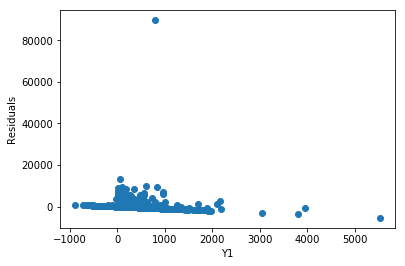

In [23]:
epsilon1 = Y-Y1

plotfig(np.array(Y1), np.array(epsilon1),'Y1','Residuals')

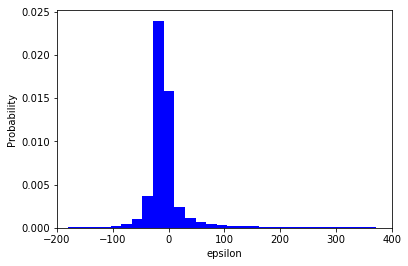

In [35]:
plt.hist(epsilon1, bins=5000,facecolor = "Blue",normed=True)
plt.xlim(-200,400)
plt.xlabel('epsilon')
plt.ylabel('Probability')
plt.show()

In [12]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
model = lm.fit(X,Y)
model.coef_.tolist()

[[-2.9062096075488895,
  1.6774140933051827,
  -0.0019616795418050457,
  1.1609953422698676,
  -0.001644794260253971,
  -1.0357489859743971e-07]]

In [13]:
model.score(X, Y)

0.02688452566793198

In [14]:
Y_pred = model.predict(X)

In [15]:
import util
util.getSSE(Y,Y_pred)

13391707382.638426

In [16]:
util.getMAPE(Y,Y_pred)

541.54154634739461

In [20]:
def plotfig(X, Y, x_label, y_label):
    #Plot figures for q5 partd
    plt.scatter(X, Y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

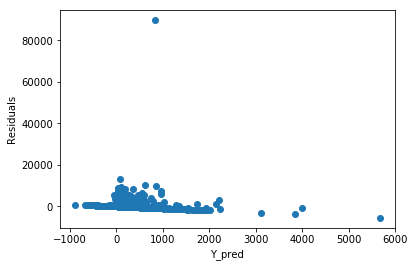

In [24]:
epsilon = Y-Y_pred

plotfig(np.array(Y_pred), np.array(epsilon),'Y_pred','Residuals')

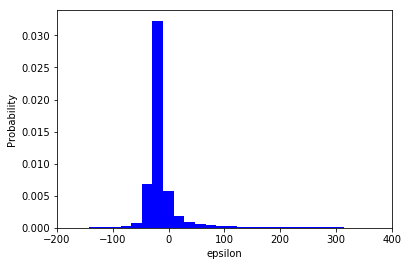

In [36]:
plt.hist(epsilon, bins=5000, facecolor = "Blue", normed=True)
plt.xlim(-200,400)
plt.xlabel('epsilon')
plt.ylabel('Probability')
plt.show()

# PART B

In [37]:
X_new = X[:,0:2]

In [39]:
lm = LinearRegression()
model1 = lm.fit(X_new,Y)
model1.coef_.tolist()

[[-3.6627637021239496, 3.610223476674924]]

In [41]:
model1.score(X_new, Y)

0.0010602549706654196

In [43]:
Y2 = model1.predict(X_new)

In [44]:
util.getSSE(Y,Y2)

13747092828.312309

In [45]:
util.getMAPE(Y,Y2)

599.5301776720288

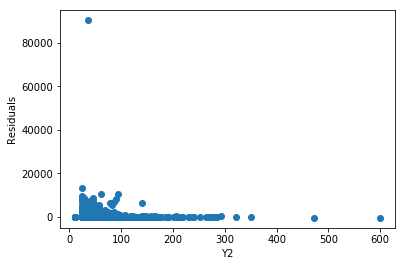

In [46]:
epsilon2 = Y-Y2
plotfig(np.array(Y2), np.array(epsilon2),'Y2','Residuals')

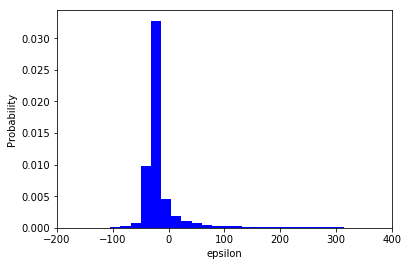

In [47]:
plt.hist(epsilon2, bins=5000, facecolor = "Blue", normed=True)
plt.xlim(-200,400)
plt.xlabel('epsilon')
plt.ylabel('Probability')
plt.show()

In [54]:
import scipy
from scipy.stats import pearsonr
import math
import seaborn as sns

In [58]:
X3 = X.copy()
X3[:,0] = Y[:,0]
ncols = 6
cvalue = 0
corrs = []
for i in range(0, ncols):
    data1 = X[:,i:i+1]
    cvalue = cvalue + 1
    
    #get second column from dataset
    for j in range(0, ncols):
        data2 = X[:,j:j+1]
        
        #calculating pearson correlation
        corr, n_corr = scipy.stats.pearsonr(data1,data2)
        
        #appending the correlation into array
        corrs.append(corr)

In [61]:
inv_colnames = ['CD','COC','CC','FC','LC', 'WC']
colnames = ['WC', 'LC', 'FC', 'CC', 'COC', 'CD']

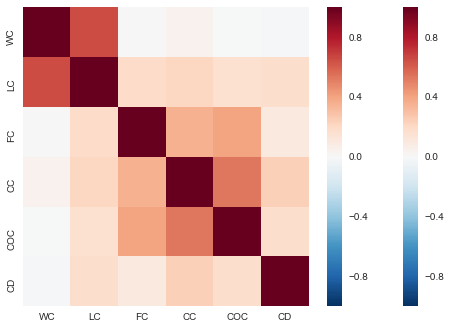

In [62]:
#creating heatmap using seaborn library
a = np.array(corrs).reshape(cvalue,cvalue)
ax = sns.heatmap(a)
ax.set_yticklabels(inv_colnames)
ax.set_xticklabels(colnames)
plt.show()